In [1]:
import os, warnings
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter
from typing import Tuple
warnings.simplefilter('ignore', FutureWarning)

In [2]:
pth_data = os.path.join('..', '..', 'data', 'modeling', 'inputs')
# pth_out = os.path.join('..', 'figures', 'survival')

In [3]:
adata = sc.read_h5ad(os.path.join(pth_data, 'TCGA.h5ad'))
adata

AnnData object with n_obs × n_vars = 10535 × 856
    obs: '_PATIENT', 'cancer type abbreviation', 'age_at_initial_pathologic_diagnosis', 'gender', 'race', 'ajcc_pathologic_tumor_stage', 'clinical_stage', 'histological_type', 'histological_grade', 'initial_pathologic_dx_year', 'menopause_status', 'birth_days_to', 'vital_status', 'tumor_status', 'last_contact_days_to', 'death_days_to', 'cause_of_death', 'new_tumor_event_type', 'new_tumor_event_site', 'new_tumor_event_site_other', 'new_tumor_event_dx_days_to', 'treatment_outcome_first_course', 'margin_status', 'residual_tumor', 'OS', 'OS.time', 'DSS', 'DSS.time', 'DFI', 'DFI.time', 'PFI', 'PFI.time', 'Redaction'

In [26]:
# cancer_types_dict = {
#     'ACC'  : 'Adrenocortical Cancer',
#     'BLCA' : 'Bladder Cancer',
#     'BRCA' : 'Breast Cancer',
#     'CESC' : 'Cervical Cancer',
#     'CHOL' : 'Bile Duct Cancer',
#     'COAD' : 'Colon Cancer',
#     'DLBC' : 'Large B-cell Lymphoma',
#     'ESCA' : 'Esophageal Cancer',
#     'GBM'  : 'Glioblastoma',
#     'HNSC' : 'Head and Neck Cancer',
#     'KICH' : 'Kidney Chromophobe',
#     'KIRC' : 'Kidney Clear Cell Carcinoma',
#     'KIRP' : 'Kidney Papillary Cell Carcinoma',
#     'LAML' : 'Acute Myeloid Leukemia',
#     'LGG'  : 'Lower Grade Glioma',
#     'LIHC' : 'Liver Cancer',
#     'LUAD' : 'Lung Adenocarcinoma',
#     'LUSC' : 'Lung Squamous Cell Carcinoma',
#     'MESO' : 'Mesothelioma',
#     'OV'   : 'Ovarian Cancer',
#     'PAAD' : 'Pancreatic Cancer',
#     'PCPG' : 'Pheochromocytoma & Paraganglioma',
#     'PRAD' : 'Prostate Cancer',
#     'READ' : 'Rectal Cancer',
#     'SARC' : 'Sarcoma',
#     'SKCM' : 'Melanoma',
#     'STAD' : 'Stomach Cancer',
#     'TGCT' : 'Testicular Cancer',
#     'THCA' : 'Thyroid Cancer',
#     'THYM' : 'Thymoma',
#     'UCEC' : 'Endometrioid Cancer',
#     'UCS'  : 'Uterine Carcinosarcoma',
#     'UVM'  : 'Ocular Melanomas'}

survival_types_dict = {
    'OS'  : 'Overall Survival',
    'DSS' : 'Disease-Specific Survival',
    'DFI' : 'Disease-Free Interval',
    'PFI' : 'Progresssion-Free Interval'}

In [46]:
from typing import List

def fit_survival(adata: ad.AnnData,
                 genes: List[str],
                 survival_type: str,
                 ) -> plt.Axes:

    # select cancer type & gene
    df = adata.obs.copy()
    df[genes] = adata[:, genes].X.toarray()

    # deduplicate patients
    survival_type_time = survival_type + '.time'
    agg_dict = {survival_type      : 'first',
                survival_type_time : 'first'}
    for g in genes: agg_dict[g] = 'mean'
    cols = list(agg_dict.keys())
    df[cols] = df[cols].astype(float)
    agg_dict['cancer type abbreviation'] = 'first'
    df = df.groupby('_PATIENT').agg(agg_dict).dropna(subset = list(agg_dict.keys()))
    df['cancer type abbreviation'] = df['cancer type abbreviation'].astype(str)
    df[survival_type_time] /= 365.

    cph = CoxPHFitter()
    cph.fit(df,
            survival_type_time,
            event_col = survival_type,
            strata = 'cancer type abbreviation')
    ax = cph.plot()
    return ax

OS


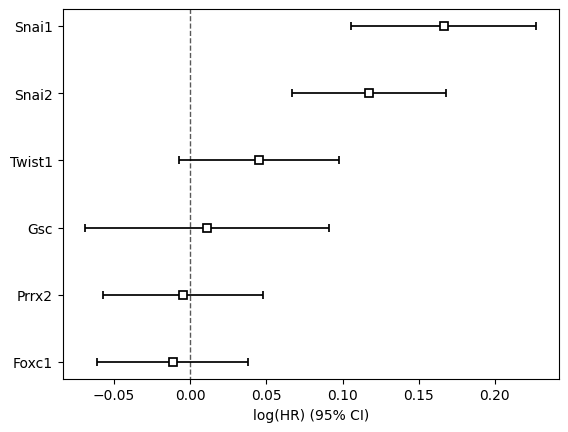

DSS


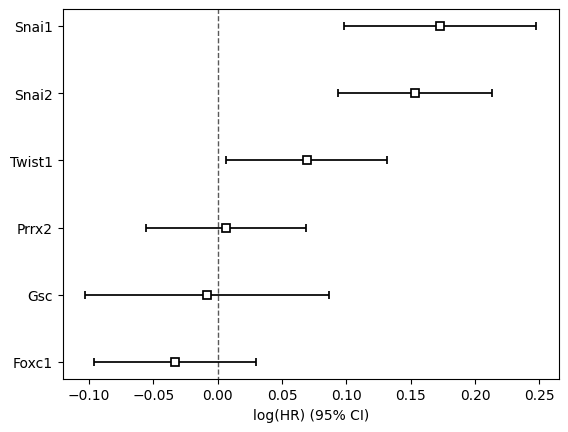

DFI


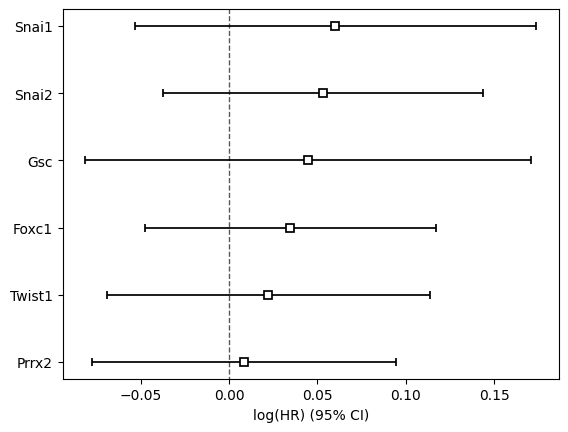

PFI


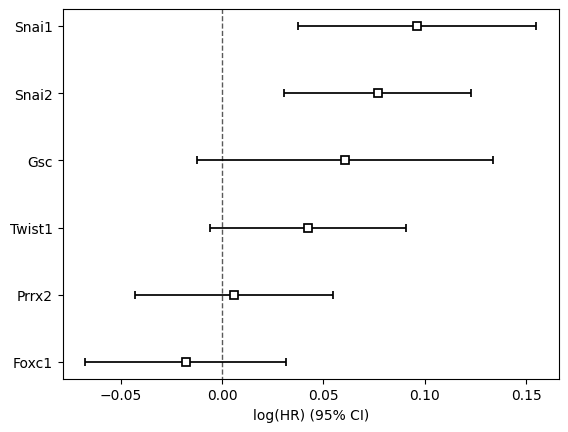

In [47]:
genes = ['Gsc', 'Foxc1', 'Twist1', 'Snai1', 'Snai2', 'Prrx2']
for survival_type, survival_name in survival_types_dict.items():
    print(survival_type)
    ax = fit_survival(adata, genes, survival_type)
    plt.show()